In [39]:
#%env CUDA_VISIBLE_DEVICES=1

In [40]:
import os
import numpy as np
import matplotlib.pyplot as plt
import cv2
from PIL import Image
import tensorflow as tf
from tensorflow.keras.models import Model,Sequential, load_model,model_from_json

%matplotlib inline

In [41]:
from tensorflow.compat.v1.keras.backend import set_session 
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True
sess=tf.compat.v1.Session(config=config)
set_session(sess)

2022-08-03 15:40:23.047599: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-03 15:40:23.047621: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [42]:
from facial_analysis import FacialImageProcessing
imgProcessing=FacialImageProcessing(False)

2022-08-03 15:40:23.113191: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2022-08-03 15:40:23.113213: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


# Tensorflow

In [43]:
model=load_model('../models/affectnet_emotions/mobilenet_7.h5')
model.summary()

Model: "model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 conv1_pad (ZeroPadding2D)   (None, 225, 225, 3)       0         
                                                                 
 conv1 (Conv2D)              (None, 112, 112, 32)      864       
                                                                 
 conv1_bn (BatchNormalizatio  (None, 112, 112, 32)     128       
 n)                                                              
                                                                 
 conv1_relu (ReLU)           (None, 112, 112, 32)      0         
                                                                 
 conv_dw_1 (DepthwiseConv2D)  (None, 112, 112, 32)     288       
                                                           

In [44]:
def mobilenet_preprocess_input(x,**kwargs):
    x[..., 0] -= 103.939
    x[..., 1] -= 116.779
    x[..., 2] -= 123.68
    return x
preprocessing_function=mobilenet_preprocess_input
INPUT_SIZE = (224, 224)

In [45]:
idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}

2022-08-03 15:40:24.125382: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 15:40:25.265153: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-08-03 15:40:25.471956: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
/var/folders/8r/02yzgnys1y70vj544xzkpcjc0000gn/T/ipykernel_9625/722285238.py:11: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/r

1/1 [==============================] - 0s 17ms/step


2022-08-03 15:40:25.740890: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


1/1 [==============================] - 0s 15ms/step


error: OpenCV(4.6.0) /Users/runner/miniforge3/conda-bld/libopencv_1658893788286/work/modules/imgproc/src/resize.cpp:4052: error: (-215:Assertion failed) !ssize.empty() in function 'resize'


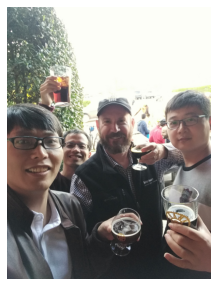

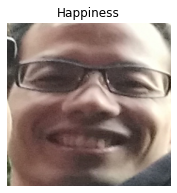

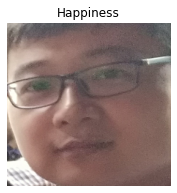

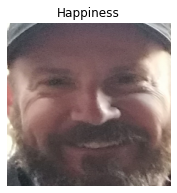

In [46]:
import matplotlib.pyplot as plt
fpath='../test_images/photo/WeChat Image_20181019083319.jpg'
frame_bgr=cv2.imread(fpath)
plt.figure(figsize=(5, 5))
plt.axis('off')
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.imshow(frame)
bounding_boxes, points = imgProcessing.detect_faces(frame)
points = points.T
for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    face_img=cv2.resize(face_img,INPUT_SIZE)
    inp=face_img.astype(np.float32)
    inp[..., 0] -= 103.939
    inp[..., 1] -= 116.779
    inp[..., 2] -= 123.68
    inp = np.expand_dims(inp, axis=0)
    scores=model.predict(inp)[0]
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(face_img)
    plt.title(idx_to_class[np.argmax(scores)])

In [ ]:
# Code borrowed from https://keras.io/examples/vision/grad_cam/
import matplotlib.cm as cm
def make_gradcam_heatmap(img_array, model, last_conv_layer_name, pred_index=None):
    # First, we create a model that maps the input image to the activations
    # of the last conv layer as well as the output predictions
    grad_model = tf.keras.models.Model(
        [model.inputs], [model.get_layer(last_conv_layer_name).output, model.output]
    )

    # Then, we compute the gradient of the top predicted class for our input image
    # with respect to the activations of the last conv layer
    with tf.GradientTape() as tape:
        last_conv_layer_output, preds = grad_model(img_array)
        if pred_index is None:
            pred_index = tf.argmax(preds[0])
        class_channel = preds[:, pred_index]

    # This is the gradient of the output neuron (top predicted or chosen)
    # with regard to the output feature map of the last conv layer
    grads = tape.gradient(class_channel, last_conv_layer_output)

    # This is a vector where each entry is the mean intensity of the gradient
    # over a specific feature map channel
    pooled_grads = tf.reduce_mean(grads, axis=(0, 1, 2))

    # We multiply each channel in the feature map array
    # by "how important this channel is" with regard to the top predicted class
    # then sum all the channels to obtain the heatmap class activation
    last_conv_layer_output = last_conv_layer_output[0]
    heatmap = last_conv_layer_output @ pooled_grads[..., tf.newaxis]
    heatmap = tf.squeeze(heatmap)

    # For visualization purpose, we will also normalize the heatmap between 0 & 1
    heatmap = tf.maximum(heatmap, 0) / tf.math.reduce_max(heatmap)
    return heatmap.numpy()
def save_and_display_gradcam(face_img, alpha=0.4):
    last_conv_layer_name = "conv_pw_13"
    inp=face_img.astype(np.float32)
    inp=preprocessing_function(inp)
    inp = np.expand_dims(inp, axis=0)
    # Remove last layer's softmax
    model.layers[-1].activation = None

    # Print what the top predicted class is
    scores = model.predict(inp)[0]

    # Generate class activation heatmap
    heatmap = make_gradcam_heatmap(inp, model, last_conv_layer_name)

    # Rescale heatmap to a range 0-255
    heatmap = np.uint8(255 * heatmap)

    # Use jet colormap to colorize heatmap
    jet = cm.get_cmap("jet")

    # Use RGB values of the colormap
    jet_colors = jet(np.arange(256))[:, :3]
    jet_heatmap = jet_colors[heatmap]

    # Create an image with RGB colorized heatmap
    jet_heatmap = tf.keras.preprocessing.image.array_to_img(jet_heatmap)
    jet_heatmap = jet_heatmap.resize((face_img.shape[1], face_img.shape[0]))
    jet_heatmap = tf.keras.preprocessing.image.img_to_array(jet_heatmap)

    # Superimpose the heatmap on original image
    superimposed_img = jet_heatmap * alpha + face_img
    superimposed_img = tf.keras.preprocessing.image.array_to_img(superimposed_img)
    #superimposed_img.save(cam_path)
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.title(idx_to_class[np.argmax(scores)])
    plt.imshow(superimposed_img)


for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    face_img=cv2.resize(face_img,INPUT_SIZE)
    save_and_display_gradcam(face_img)

# PyTorch

In [47]:
import torch
from PIL import Image
from torchvision import transforms
use_mps = torch.has_mps
print(use_mps)
device = 'mps' if use_mps else 'cpu'

True


In [48]:
USE_ENET2=True
NUM_EMOTIONS=8 #7 #
if NUM_EMOTIONS==7:
    idx_to_class={0: 'Anger', 1: 'Disgust', 2: 'Fear', 3: 'Happiness', 4: 'Neutral', 5: 'Sadness', 6: 'Surprise'}
else:
    idx_to_class={0: 'Anger', 1: 'Contempt', 2: 'Disgust', 3: 'Fear', 4: 'Happiness', 5: 'Neutral', 6: 'Sadness', 7: 'Surprise'}
if USE_ENET2:
    IMG_SIZE=260
    if NUM_EMOTIONS==7: # 7 emotions
        PATH='../models/affectnet_emotions/enet_b2_7.pt'
    else:
        PATH='../models/affectnet_emotions/enet_b2_8.pt'
else:
    IMG_SIZE=224
    if NUM_EMOTIONS==7: # 7 emotions from AFFECT_IMG_SEVEN_TRAIN_DATA_DIR and AFFECT_IMG_SEVEN_VAL_DATA_DIR
        PATH='../models/affectnet_emotions/enet_b0_7.pt'
    else:
        #PATH='../models/affectnet_emotions/enet_b0_8_best_vgaf.pt'
        PATH='../models/affectnet_emotions/enet_b0_8_best_afew.pt'

In [49]:
test_transforms = transforms.Compose(
    [
        transforms.Resize((IMG_SIZE,IMG_SIZE)),
        transforms.ToTensor(),
        transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                     std=[0.229, 0.224, 0.225])
    ]
)
model = torch.load(PATH,map_location=torch.device('cpu'))
model=model.to(device)
model.eval()

EfficientNet(
  (conv_stem): Conv2dSame(3, 32, kernel_size=(3, 3), stride=(2, 2), bias=False)
  (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
  (act1): SiLU(inplace=True)
  (blocks): Sequential(
    (0): Sequential(
      (0): DepthwiseSeparableConv(
        (conv_dw): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
        (bn1): BatchNorm2d(32, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act1): SiLU(inplace=True)
        (se): SqueezeExcite(
          (conv_reduce): Conv2d(32, 8, kernel_size=(1, 1), stride=(1, 1))
          (act1): SiLU(inplace=True)
          (conv_expand): Conv2d(8, 32, kernel_size=(1, 1), stride=(1, 1))
        )
        (conv_pw): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn2): BatchNorm2d(16, eps=0.001, momentum=0.1, affine=True, track_running_stats=True)
        (act2): Identity()
      )
      (1): DepthwiseSeparableConv(


/var/folders/8r/02yzgnys1y70vj544xzkpcjc0000gn/T/ipykernel_9625/4280580915.py:10: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  box = bbox.astype(np.int)


ValueError: tile cannot extend outside image

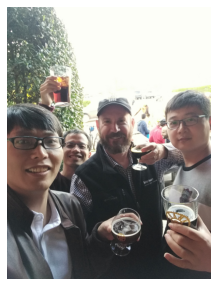

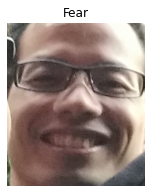

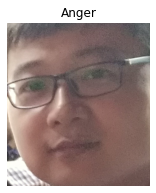

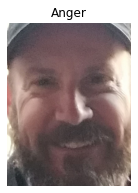

In [50]:
fpath='../test_images/photo/WeChat Image_20181019083319.jpg'
frame_bgr=cv2.imread(fpath)
plt.figure(figsize=(5, 5))
frame = cv2.cvtColor(frame_bgr, cv2.COLOR_BGR2RGB)
plt.axis('off')
plt.imshow(frame)
bounding_boxes, points = imgProcessing.detect_faces(frame)
points = points.T
for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    img_tensor = test_transforms(Image.fromarray(face_img))
    img_tensor.unsqueeze_(0)
    scores = model(img_tensor.to(device))
    scores=scores[0].data.cpu().numpy()
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(face_img)
    plt.title(idx_to_class[np.argmax(scores)])

In [ ]:
from pytorch_grad_cam import GradCAM, ScoreCAM, GradCAMPlusPlus, AblationCAM, XGradCAM, EigenCAM
from pytorch_grad_cam.utils.image import show_cam_on_image
target_layers = [model.blocks[-1][-1]]
# Construct the CAM object once, and then re-use it on many images:
cam = GradCAM(model=model, target_layers=target_layers,use_cuda=use_mps)

for bbox,p in zip(bounding_boxes, points):
    box = bbox.astype(np.int)
    x1,y1,x2,y2=box[0:4]    
    face_img=frame[y1:y2,x1:x2,:]
    
    img_tensor = test_transforms(Image.fromarray(face_img))
    img_tensor.unsqueeze_(0)
    scores = model(img_tensor.to(device))
    scores=scores[0].data.cpu().numpy()
    grayscale_cam = cam(input_tensor=img_tensor, target_category=None)
    grayscale_cam = grayscale_cam[0, :]
    face_img=cv2.resize(face_img,(IMG_SIZE,IMG_SIZE))
    rgb_img = np.float32(face_img) / 255
    visualization = show_cam_on_image(rgb_img, grayscale_cam, use_rgb=True)
    plt.figure(figsize=(3, 3))
    plt.axis('off')
    plt.imshow(visualization)
    plt.title(idx_to_class[np.argmax(scores)])

In [ ]:
imgProcessing.close()